<a href="https://colab.research.google.com/github/shree180103/dcgan_mnist/blob/main/dcgan_with_fid_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

In [2]:
torch.cuda.is_available()

True

In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [4]:
class Discriminator(nn.Module):
  def __init__(self,input_shape:int,num_classes:int,img_size:int):
    super().__init__()
    self.img_size=img_size
    self.conv_layer=nn.Sequential(
        nn.Conv2d(in_channels=input_shape+1,out_channels=64,kernel_size=4,stride=2,padding=1,bias=False),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(in_channels=64,out_channels=128,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(in_channels=128,out_channels=256,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(in_channels=256,out_channels=512,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(in_channels=512,out_channels=1,kernel_size=4,stride=1,padding=0,bias=False),
        nn.Sigmoid()
    )

    self.embed=nn.Embedding(num_embeddings=num_classes,embedding_dim=img_size*img_size)

  def forward(self,x,labels):
    embedding=self.embed(labels).view(labels.shape[0],1,self.img_size,self.img_size)
    x=torch.cat([x,embedding],dim=1)
    return self.conv_layer(x)

     


In [5]:
class Generator(nn.Module):
  def __init__(self,z_dim:int,img_channels:int,num_classes:int,img_size:int,embed_size:int):
    super().__init__()
    self.img_size=img_size
    self.trans_conv_layer=nn.Sequential(
        nn.ConvTranspose2d(in_channels=z_dim+embed_size,out_channels=512,kernel_size=4,stride=1,padding=0,bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=4,stride=2,padding=1,bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.ConvTranspose2d(in_channels=64,out_channels=img_channels,kernel_size=4,stride=2,padding=1,bias=False),
        nn.Tanh()


    )
    self.embed=nn.Embedding(num_classes,embed_size)

  def forward(self,x,labels):
    embedding=self.embed(labels).unsqueeze(2).unsqueeze(3) # to get extra dim at position 2 and 3 so that z=[n,z_dim,1,1]
    x=torch.cat([x,embedding],dim=1)
    return self.trans_conv_layer(x)




In [6]:
batch_size=128
lr=0.0002
z_dim=100
img_size=64
n_c=1
embed_size=100
transform=transforms.Compose(transforms=[transforms.ToTensor(),
                                         transforms.Resize((64,64)),
                                         transforms.CenterCrop(img_size),
                                         transforms.Normalize([0.5 for _ in range(n_c)],[0.5 for _ in range(n_c)])])
dataset=datasets.MNIST(root="data",transform=transform,download=True)
data_loader=DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True)

num_classes=len(dataset.classes)


In [7]:
device="cuda" if torch.cuda.is_available() else "cpu"
n_c=1

gen=Generator(z_dim=100,img_channels=n_c,num_classes=num_classes,img_size=img_size,embed_size=embed_size).to(device)
gen.apply(weights_init)

disc=Discriminator(input_shape=n_c,num_classes=num_classes,img_size=img_size).to(device)
disc.apply(weights_init)


Discriminator(
  (conv_layer): Sequential(
    (0): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
  (embed): Embedding(10, 4

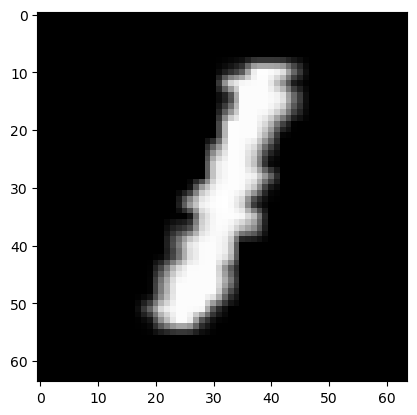

In [8]:
image,label=next(iter(data_loader))
import matplotlib.pyplot as plt
plt.imshow(image[0].reshape(64,64),cmap='gray')
plt.show()

In [9]:
loss_fn=nn.BCELoss()
optimizer_disc=torch.optim.Adam(params=disc.parameters(),lr=lr,betas=(0.5,0.999))
optimizer_gen=torch.optim.Adam(params=gen.parameters(),lr=lr,betas=(0.5,0.999))
     

writer_fake=SummaryWriter(f"runs/GAN_MNIST/fake")

writer_real=SummaryWriter(f"runs/GAN_MNIST/real")

step = 0

fixed_noise = torch.randn(size=(128,z_dim,1,1))
     

In [10]:
# z=torch.rand(size=(1,100,1,1))
# z.shape

In [11]:
# img,label=next(iter(data_loader))
# img.shape

In [12]:
!pip install torchinfo

In [13]:
from torchinfo import summary
labels = torch.randint(0, 10, (1,))
summary(disc,input_size=[1,1,64,64],labels=labels.to(device))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1, 1, 1]              --
├─Embedding: 1-1                         [1, 4096]                 40,960
├─Sequential: 1-2                        [1, 1, 1, 1]              --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           2,048
│    └─LeakyReLU: 2-2                    [1, 64, 32, 32]           --
│    └─Conv2d: 2-3                       [1, 128, 16, 16]          131,072
│    └─BatchNorm2d: 2-4                  [1, 128, 16, 16]          256
│    └─LeakyReLU: 2-5                    [1, 128, 16, 16]          --
│    └─Conv2d: 2-6                       [1, 256, 8, 8]            524,288
│    └─BatchNorm2d: 2-7                  [1, 256, 8, 8]            512
│    └─LeakyReLU: 2-8                    [1, 256, 8, 8]            --
│    └─Conv2d: 2-9                       [1, 512, 4, 4]            2,097,152
│    └─BatchNorm2d: 2-10                 [1, 512, 4, 4]    

In [14]:
# disc.eval()
# with torch.inference_mode():
#   print(disc(torch.rand(size=(1,1,64,64)).to('cuda')).shape)


In [15]:
# disc.eval()
# with torch.inference_mode():
#   print(disc(torch.rand(size=(1,1,64,64)).to('cuda')).shape)

In [16]:

labels = torch.randint(0, 10, (1,))

summary(gen,input_size=[1,100,1,1],labels=labels.to(device))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 1, 64, 64]            --
├─Embedding: 1-1                         [1, 100]                  1,000
├─Sequential: 1-2                        [1, 1, 64, 64]            --
│    └─ConvTranspose2d: 2-1              [1, 512, 4, 4]            1,638,400
│    └─BatchNorm2d: 2-2                  [1, 512, 4, 4]            1,024
│    └─ReLU: 2-3                         [1, 512, 4, 4]            --
│    └─ConvTranspose2d: 2-4              [1, 256, 8, 8]            2,097,152
│    └─BatchNorm2d: 2-5                  [1, 256, 8, 8]            512
│    └─ReLU: 2-6                         [1, 256, 8, 8]            --
│    └─ConvTranspose2d: 2-7              [1, 128, 16, 16]          524,288
│    └─BatchNorm2d: 2-8                  [1, 128, 16, 16]          256
│    └─ReLU: 2-9                         [1, 128, 16, 16]          --
│    └─ConvTranspose2d: 2-10             [1, 64, 32, 32]  

In [17]:
# gen.eval()
# with torch.inference_mode():
#   print(gen(z.to('cuda')).shape)

In [18]:
import math
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import inception_v3
from torchvision.models import Inception_V3_Weights
import scipy
import numpy as np

In [19]:
from tqdm.auto import tqdm

epochs=15
LOSS_D=[]
LOSS_G=[]
fid_scores=[]

for epoch in tqdm(range(epochs)):
  for batch_idx,(x,labels) in enumerate(data_loader):
    x=x.to(device)
    labels=labels.to(device)
    cur_batch_size=x.shape[0]
    z=torch.randn(size=(cur_batch_size,100,1,1),device=device)

    ## traing the discriminator

    disc.zero_grad()
    disc_real=disc(x.to('cuda'),labels.to('cuda')).reshape(-1)
    loss_disc_real=loss_fn(disc_real,torch.full_like(disc_real,0.9))
    loss_disc_real.backward()


    fake=gen(z.to('cuda'),labels.to('cuda'))
    disc_fake=disc(fake.detach().to('cuda'),labels.to('cuda')).reshape(-1)
    loss_disc_fake=loss_fn(disc_fake,torch.zeros_like(disc_fake))
    loss_disc_fake.backward()

    loss_disc=loss_disc_fake+loss_disc_real
    LOSS_D.append(loss_disc.item())

    optimizer_disc.step()

    #training generator
    gen.zero_grad()

    fool_logits=disc(fake.to('cuda'),labels.to('cuda')).reshape(-1)
    loss_gen=loss_fn(fool_logits,torch.ones_like(fool_logits))
    LOSS_G.append(loss_gen.item())

    loss_gen.backward()

    optimizer_gen.step()

    if batch_idx== 0:
            print(
                f"Epoch [{epoch}/{epochs}] Batch {batch_idx}/{len(data_loader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(z.to('cuda'),labels.to('cuda')).detach()
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(x[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1










     


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch [0/15] Batch 0/469                   Loss D: 2.3094, loss G: 7.5834
Epoch [1/15] Batch 0/469                   Loss D: 0.8183, loss G: 2.7251
Epoch [2/15] Batch 0/469                   Loss D: 0.8746, loss G: 4.0570
Epoch [3/15] Batch 0/469                   Loss D: 0.7585, loss G: 3.3851
Epoch [4/15] Batch 0/469                   Loss D: 0.9699, loss G: 2.7725
Epoch [5/15] Batch 0/469                   Loss D: 0.6418, loss G: 3.5148
Epoch [6/15] Batch 0/469                   Loss D: 0.6341, loss G: 4.3596
Epoch [7/15] Batch 0/469                   Loss D: 0.7103, loss G: 3.3953
Epoch [8/15] Batch 0/469                   Loss D: 0.7313, loss G: 3.1132
Epoch [9/15] Batch 0/469                   Loss D: 0.4634, loss G: 4.3466
Epoch [10/15] Batch 0/469                   Loss D: 0.5170, loss G: 4.9601
Epoch [11/15] Batch 0/469                   Loss D: 1.0083, loss G: 3.8937
Epoch [12/15] Batch 0/469                   Loss D: 0.4723, loss G: 4.0688
Epoch [13/15] Batch 0/469          

In [20]:
noise=torch.rand(size=(batch_size,z_dim,1,1)).to(device)
labels=torch.randint(0,10,(batch_size,)).to(device)
gen_img=gen(noise,labels)

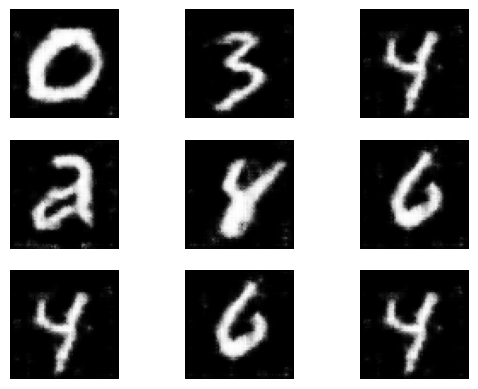

In [21]:
with torch.inference_mode():
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(gen_img[i].cpu().squeeze(),cmap="gray")
    plt.axis(False)
     

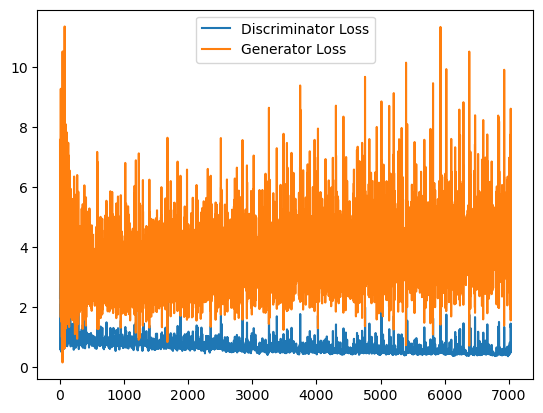

In [22]:
plt.plot(LOSS_D,label="Discriminator Loss")
plt.plot(LOSS_G,label="Generator Loss")
plt.legend()
plt.show()

In [23]:
class PartialInceptionNetwork(nn.Module):
  def __init__(self):
    super(PartialInceptionNetwork, self).__init__()
    self.inception_model = inception_v3(weights=Inception_V3_Weights.DEFAULT)  #initializing pretrsined model
    self.inception_model.Mixed_7c.register_forward_hook(self.output_hook)
    self.output = None

  def output_hook(self, module, input, output):
    self.mixed_7c_output = output

  def forward(self, x):
    assert x.shape[1:] == (3, 299, 299), "Input shape should be (batch_size, 3, 299, 299)"
    self.inception_model(x)
    activations = self.mixed_7c_output
    activations = F.adaptive_avg_pool2d(activations, (1, 1))
    activations = activations.view(x.shape[0],2048)
    return activations

net=PartialInceptionNetwork().to(device)

def fid_score(real_images, gen_images,batch_size):
  real_activations = []
  gen_activations = []
  num_steps=int(math.ceil(float(len(real_images))/float(batch_size)))
  for i in range(num_steps):
    s = i * batch_size
    e=(1+i) * batch_size

    mini_real_batch=real_images[s:e]
    mini_gen_batch=gen_images[s:e]

    batch_real=Variable(mini_real_batch).to(device)
    batch_gen=Variable(mini_gen_batch).to(device)

  features_real=net(batch_real)
  features_gen=net(batch_gen)

  real_activations.append(features_real)
  gen_activations.append(features_gen)

  features_real=torch.cat(real_activations,0)
  features_gen=torch.cat(gen_activations,0)

  xr=features_real.cpu().detach().numpy()
  xg=features_gen.cpu().detach().numpy()

  u1=np.mean(xr,axis=0)
  u2=np.mean(xg,axis=0)
  s1=np.cov(xr,rowvar=False)
  s2=np.cov(xg,rowvar=False)

  diff=u1-u2
  diff_squared=diff.dot(diff)

  prod=np.dot(s1,s2)

  sqrt_prod,_=scipy.linalg.sqrtm(prod,disp=False)

  if np.iscomplexobj(sqrt_prod):
      sqrt_prod=sqrt_prod.real

  prod_tr=np.trace(sqrt_prod)

  fid_score=diff_squared+np.trace(s1)+np.trace(s2)-2*prod_tr

  return fid_score

In [30]:
x,label=next(iter(data_loader))
x=x[0:32]
gen_img=gen_img[0:32]
gen_images=gen_img.view(-1,1,64,64)
gen_images=gen_images.repeat(1,3,1,1)
gen_res_images=F.interpolate(gen_images,size=(299,299))
real_images = x.view(-1, 1, 64, 64) # Reshape real_images similar to gen_images
real_images = real_images.repeat(1, 3, 1, 1) # Repeat channels for real_images
real_images = F.interpolate(real_images, size=(299, 299)) # Resize 
net.eval()  # Set the model to evaluation mode
fid = fid_score(real_images, gen_res_images,32)
print(fid)

176.1663006060922


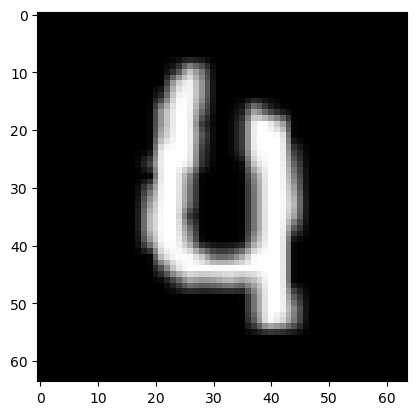

In [25]:
image,labels=next(iter(data_loader))
plt.imshow(image[0].reshape(64,64),cmap="gray")

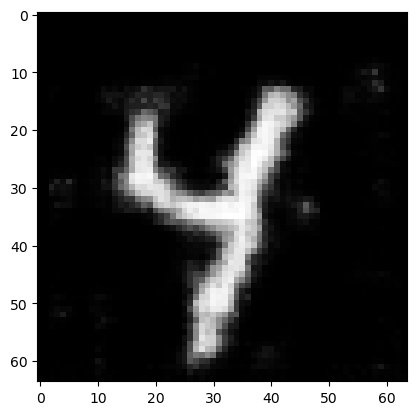

In [26]:
noise=torch.rand(size=(128,z_dim,1,1)).to(device)
gen_img=gen(noise,labels.to(device))
plt.imshow(gen_img[0].cpu().detach().squeeze(),cmap="gray")


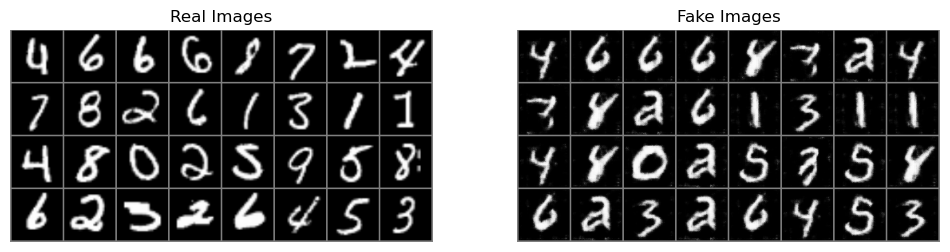

In [27]:

from torchvision.utils import make_grid

# Display images
def show_images(real_images, fake_images):


    

    # Create a grid of images
    real_grid = make_grid(real_images, nrow=8)
    fake_grid = make_grid(fake_images, nrow=8)

    plt.figure(figsize=(12, 6))

    # Plot real images
    plt.subplot(1, 2, 1)
    plt.title("Real Images")
    plt.imshow((real_grid*0.5+0.5).permute(1, 2, 0).numpy())
    plt.axis('off')

    # Plot fake images
    plt.subplot(1, 2, 2)
    plt.title("Fake Images")
    plt.imshow((fake_grid*0.5+0.5).cpu().permute(1, 2, 0).numpy())
    plt.axis('off')

    plt.show()

# Hyperparameters
batch_size = 32
noise_dim = 100

show_images(image[:32],gen_img[:32])
